# GRU Forecasting Bitcoin Price

---





## 1. Introduction

Historical data of cryptocurrency prices will be used to predict Adjusted Close prices by building a multi-layer Recurrent Neural Network model. The ability to store information over a period of time is useful when dealing with time series data.


##2. Import/Install Library

In [1]:
import yfinance as yf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import seaborn as sns
import math
import datetime
import keras
import warnings
import tensorflow as tf
import random as rn
warnings.filterwarnings('ignore')

from datetime import date, timedelta
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import GRU, LSTM, SimpleRNN
from keras.layers import Dropout
from keras.layers import *
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.feature_selection import SelectKBest, f_regression
from google.colab import data_table
data_table.enable_dataframe_formatter()

%matplotlib inline

## 3. Import data

Read in cryptocurrency data  downloaded from Yahoo! Finance using yfinance API into a pandas DataFrame.

In [2]:
### Unduh data dengan API Yfinance dan dijadikan DataFrame
#stock_kode = input("Masukkan Simbol Kode Saham : ")
#range_start_historical_data = input("Masukkan rentang awal historical data format: yyyy-mm-dd : ")
#range_end_historical_data = input("Masukkan rentang akhir historical data format: yyyy-mm-dd : ")
#stock_kode_df = yf.download(stock_kode, range_start_historical_data, range_end_historical_data)

In [3]:
stock_kode = "BTC-USD"##input("Masukkan Simbol Kode Saham : ")
stock_kode_df = yf.download(stock_kode, start = "2018-08-04", end = "2023-08-04")
stock_kode_df.to_csv("data.csv")

df = pd.read_csv("data.csv")
df['Date'] = pd.to_datetime(df['Date'])

print(df['Date'])
print(df['Date'].tail(1))

[*********************100%%**********************]  1 of 1 completed

0      2018-08-04
1      2018-08-05
2      2018-08-06
3      2018-08-07
4      2018-08-08
          ...    
1821   2023-07-30
1822   2023-07-31
1823   2023-08-01
1824   2023-08-02
1825   2023-08-03
Name: Date, Length: 1826, dtype: datetime64[ns]
1825   2023-08-03
Name: Date, dtype: datetime64[ns]


In [4]:
stock_kode_df.tail

<bound method NDFrame.tail of                     Open          High           Low         Close  \
Date                                                                 
2018-08-04   7438.669922   7497.490234   6984.069824   7032.850098   
2018-08-05   7031.080078   7102.770020   6940.700195   7068.479980   
2018-08-06   7062.939941   7166.549805   6890.540039   6951.799805   
2018-08-07   6958.319824   7146.560059   6748.240234   6753.120117   
2018-08-08   6746.850098   6746.850098   6226.220215   6305.799805   
...                  ...           ...           ...           ...   
2023-07-30  29357.093750  29443.169922  29059.501953  29275.308594   
2023-07-31  29278.314453  29489.873047  29131.578125  29230.111328   
2023-08-01  29230.873047  29675.732422  28657.023438  29675.732422   
2023-08-02  29704.146484  29987.998047  28946.509766  29151.958984   
2023-08-03  29161.812500  29375.707031  28959.488281  29178.679688   

               Adj Close       Volume  
Date                                   
2018-08-04   7032.850098   4268390000  
2018-08-05   7068.479980   3679110000  
2018-08-06   6951.799805   3925900000  
2018-08-07   6753.120117   4682800000  
2018-08-08   6305.799805   5064430000  
...                  ...          ...  
2023-07-30  29275.308594   8678454527  
2023-07-31  29230.111328  11656781982  
2023-08-01  29675.732422  18272392391  
2023-08-02  29151.958984  19212655598  
2023-08-03  29178.679688  12780357746  

[1826 rows x 6 columns]>

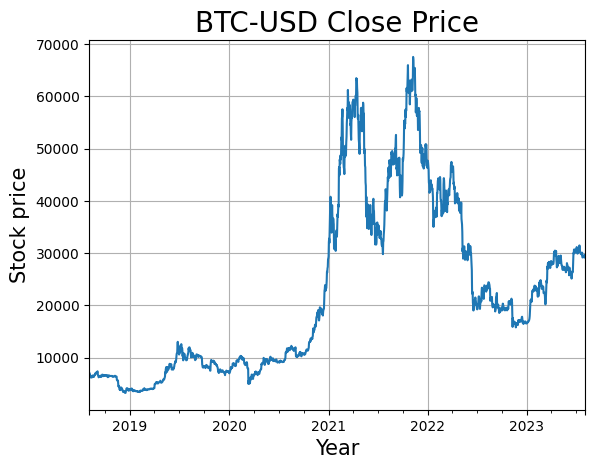

In [5]:
# Plot Adjusted Close price

stock_kode_df['Adj Close'].plot(grid = True)
sns.set(rc={'figure.figsize':(14, 8)})
plt.title(stock_kode + ' Close Price', color = 'black', fontsize = 20)
plt.xlabel('Year', color = 'black', fontsize = 15)
plt.ylabel('Stock price', color = 'black', fontsize = 15);
plt.savefig("plotBTC.png")

In [6]:
# Create DataFrame for Adjusted Close price
stock_kode_adj = stock_kode_df[['Adj Close']]

In [7]:
# Print DataFrame
stock_kode_adj

,Adj Close
Date,
2018-08-04,7032.850098
2018-08-05,7068.479980
2018-08-06,6951.799805
2018-08-07,6753.120117
2018-08-08,6305.799805
...,...
2023-07-30,29275.308594
2023-07-31,29230.111328
2023-08-01,29675.732422


##4. Create Training Data-set

In [8]:
# Convert DataFrame to numpy array
stock_kode_adj_arr = stock_kode_adj.values

# Find number of rows to train model on (80% of data set)
training_data_len = int(0.8*len(stock_kode_adj))

# Print
training_data_len

1460

In [9]:
# Create train data set

train = stock_kode_adj_arr[0:training_data_len, :]

In [10]:
train

array([[ 7032.85009766],
       [ 7068.47998047],
       [ 6951.79980469],
       ...,
       [23336.89648438],
       [23314.19921875],
       [22978.1171875 ]])

### Normalisasi Data / Feature scaling

Normalisasi data latihan sebelum memasukkan model dengan mengonversi nilai kolom numerik dalam set data menjadi skala umum. Fungsi MinMaxScaler() dari Scikit-Learn akan menyesuaikan skala data menjadi nilai antara 0 dan 1 yang membantu meningkatkan performa.

In [11]:
# Normalise the data
scaler = MinMaxScaler(feature_range=(0,1))
train_scaled = scaler.fit_transform(train)

In [12]:
# Print Normalized Data
print(train_scaled)

[[0.05900955]
 [0.05956341]
 [0.05774964]
 ...
 [0.31245319]
 [0.31210037]
 [0.30687603]]


In [13]:
train_scaled.shape

(1460, 1)

### Split training data into X_train, y_train

Kode berikut merupakan implementasi dari pembuatan data struktur untuk data time series dalam bentuk supervised learning. Data time series diubah menjadi data supervised learning dengan membuat data input (X) dan data output (y) dari data time series yang diberikan.

Kode tersebut melakukan hal berikut:

Membuat dua variabel kosong X_train dan y_train sebagai list untuk menampung data input dan output.
Melakukan iterasi untuk setiap time-step pada data latihan (train_scaled) dimulai dari time-step ke-60 hingga akhir data.
Pada setiap iterasi, dilakukan penambahan data input dan output ke dalam list X_train dan y_train. Data input (X_train) berupa 60 time-step sebelum time-step saat ini (i-60) dan data output (y_train) adalah time-step saat ini (i) pada kolom pertama (0) pada data latihan (train_scaled).
Jika i <= 61, maka akan menampilkan data input dan output pada iterasi tersebut untuk memastikan data terbentuk dengan benar. Hal ini digunakan untuk debugging dan tidak diperlukan pada saat eksekusi sebenarnya.
Dengan menggunakan kode tersebut, data time series dapat diubah menjadi data supervised learning yang dapat digunakan untuk melatih model machine learning untuk melakukan prediksi.

In [14]:
# Creating a data structure with 60 time-steps and 1 output

# Split data into X_train and y_train data sets
X_train = []
y_train = []
# Creating a data structure with 60 time-steps and 1 output
for i in range(60, len(train_scaled)):
    X_train.append(train_scaled[i-60:i, 0])
    y_train.append(train_scaled[i:i+1, 0])
    if i <= 61:     # 60 days for first pass, 61 for second
      print(X_train)
      print(y_train)
      print()

[array([0.05900955, 0.05956341, 0.05774964, 0.0546612 , 0.04770768,
       0.05178711, 0.04582536, 0.04755114, 0.04797023, 0.04757974,
       0.04605853, 0.04774996, 0.04815739, 0.05197986, 0.04954135,
       0.05082084, 0.04775011, 0.05055176, 0.04880996, 0.05126869,
       0.05414573, 0.05481773, 0.05394831, 0.05670565, 0.05999556,
       0.059232  , 0.05816049, 0.05908308, 0.06150294, 0.06273829,
       0.06254149, 0.06412085, 0.05527848, 0.05117993, 0.05021459,
       0.04646689, 0.04763089, 0.04807921, 0.04794707, 0.04842274,
       0.05099557, 0.05092406, 0.05139803, 0.05099355, 0.04732528,
       0.04872586, 0.04914931, 0.05103225, 0.05437875, 0.05417713,
       0.05400069, 0.05220962, 0.04989438, 0.05064876, 0.05347404,
       0.05296696, 0.05231144, 0.0526783 , 0.05211962, 0.05159855])]
[array([0.05076675])]

[array([0.05900955, 0.05956341, 0.05774964, 0.0546612 , 0.04770768,
       0.05178711, 0.04582536, 0.04755114, 0.04797023, 0.04757974,
       0.04605853, 0.04774996, 0.04

In [15]:
# Convert X_train and y_train to numpy arrays for training GRU model
X_train, y_train = np.array(X_train), np.array(y_train)

In [16]:
# Reshape the data as GRU expects 3-D data (samples, time steps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(1400, 60, 1)

##5. Create test set

In [17]:
# Create Data Test
test = stock_kode_adj_arr[training_data_len: , :]

In [18]:
print(test.shape)

(366, 1)


In [19]:
print(test)

[[22846.5078125 ]
 [22630.95703125]
 [23289.31445312]
 [22961.27929688]
 [23175.890625  ]
 [23809.48632812]
 [23164.31835938]
 [23947.64257812]
 [23957.52929688]
 [24402.81835938]
 [24424.06835938]
 [24319.33398438]
 [24136.97265625]
 [23883.29101562]
 [23335.99804688]
 [23212.73828125]
 [20877.55273438]
 [21166.06054688]
 [21534.12109375]
 [21398.90820312]
 [21528.08789062]
 [21395.01953125]
 [21600.90429688]
 [20260.01953125]
 [20041.73828125]
 [19616.81445312]
 [20297.99414062]
 [19796.80859375]
 [20049.76367188]
 [20127.140625  ]
 [19969.77148438]
 [19832.08789062]
 [19986.71289062]
 [19812.37109375]
 [18837.66796875]
 [19290.32421875]
 [19329.83398438]
 [21381.15234375]
 [21680.5390625 ]
 [21769.25585938]
 [22370.44921875]
 [20296.70703125]
 [20241.08984375]
 [19701.2109375 ]
 [19772.58398438]
 [20127.57617188]
 [19419.50585938]
 [19544.12890625]
 [18890.7890625 ]
 [18547.40039062]
 [19413.55078125]
 [19297.63867188]
 [18937.01171875]
 [18802.09765625]
 [19222.671875  ]
 [19110.54

In [20]:
# Predicting 253 values, using past 60 from the train data
inputs = stock_kode_adj_arr[len(stock_kode_adj_arr) - len(test) - 60:]
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

In [21]:
inputs

array([[0.41343269],
       [0.41457909],
       [0.43733687],
       [0.43399173],
       [0.41936213],
       [0.417771  ],
       [0.40178791],
       [0.39054909],
       [0.36570593],
       [0.29924774],
       [0.29488593],
       [0.30057606],
       [0.26651439],
       [0.26791082],
       [0.24531112],
       [0.26918221],
       [0.26990141],
       [0.27162782],
       [0.26038008],
       [0.27746148],
       [0.27972759],
       [0.28393529],
       [0.27655083],
       [0.27201459],
       [0.26494412],
       [0.26219873],
       [0.25723531],
       [0.24922414],
       [0.2488027 ],
       [0.24965487],
       [0.26417663],
       [0.26353701],
       [0.2691041 ],
       [0.28603773],
       [0.28749163],
       [0.28533229],
       [0.27395724],
       [0.26012401],
       [0.25007206],
       [0.26387836],
       [0.26944101],
       [0.27358228],
       [0.27908497],
       [0.27269647],
       [0.29922133],
       [0.31326988],
       [0.31081844],
       [0.309

In [22]:
# Create data sets X_test and y_test
X_test = []
y_test = stock_kode_adj_arr[training_data_len:, :]
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])

In [23]:
# Convert data to numpy array
X_test = np.array(X_test)

In [24]:
# Reshape data to be 3-D.
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [25]:
print(X_test.shape)

(366, 60, 1)


In [26]:
X_test

array([[[0.41343269],
        [0.41457909],
        [0.43733687],
        ...,
        [0.31245319],
        [0.31210037],
        [0.30687603]],

       [[0.41457909],
        [0.43733687],
        [0.43399173],
        ...,
        [0.31210037],
        [0.30687603],
        [0.30483019]],

       [[0.43733687],
        [0.43399173],
        [0.41936213],
        ...,
        [0.30687603],
        [0.30483019],
        [0.30147949]],

       ...,

       [[0.37327535],
        [0.37056339],
        [0.37124639],
        ...,
        [0.40603341],
        [0.40476481],
        [0.40406222]],

       [[0.37056339],
        [0.37124639],
        [0.35012145],
        ...,
        [0.40476481],
        [0.40406222],
        [0.41098933]],

       [[0.37124639],
        [0.35012145],
        [0.37310736],
        ...,
        [0.40406222],
        [0.41098933],
        [0.40284736]]])

##6. Creating Model and Train

###Define Hyperparameter Untuk Model

In [27]:
# Define hyperparameters
learning_rate = 0.0001
num_neurons = 100
dropout_rate = 0.2
num_epochs = 200
batch_size = 64

###Model GRU

In [28]:
# Set random seed for consistency of training
np.random.seed(8)
rn.seed(8)
tf.random.set_seed(8)

# Build model - GRU with 100 neurons and 5 hidden layers
model_gru = Sequential()
model_gru.add(GRU(units = num_neurons, return_sequences = True, input_shape = (X_train.shape[1], 1), activation='tanh'))
model_gru.add(Dropout(dropout_rate))
model_gru.add(GRU(units = num_neurons, return_sequences = True, activation='tanh'))
model_gru.add(Dropout(dropout_rate))
model_gru.add(GRU(units = num_neurons, return_sequences = True, activation='tanh'))
model_gru.add(Dropout(dropout_rate))
model_gru.add(GRU(units = num_neurons, activation='tanh'))
model_gru.add(Dropout(dropout_rate))

# Adding the output layer
model_gru.add(Dense(units = 1))

# Compiling the RNN with Adam optimizer and mean squared error as the loss function
opt = keras.optimizers.Adam(learning_rate)
model_gru.compile(optimizer = opt, loss = 'mean_squared_error')

# Fitting the RNN to the Training set
model_gru.fit(X_train, y_train, epochs = num_epochs, batch_size = batch_size)



Epoch 1/200
22/22 [==============================] - 11s 19ms/step - loss: 0.1206
Epoch 2/200
22/22 [==============================] - 0s 14ms/step - loss: 0.0238
Epoch 3/200
22/22 [==============================] - 0s 13ms/step - loss: 0.0095
Epoch 4/200
22/22 [==============================] - 0s 14ms/step - loss: 0.0044
Epoch 5/200
22/22 [==============================] - 0s 14ms/step - loss: 0.0032
Epoch 6/200
22/22 [==============================] - 0s 14ms/step - loss: 0.0034
Epoch 7/200
22/22 [==============================] - 0s 14ms/step - loss: 0.0032
Epoch 8/200
22/22 [==============================] - 0s 13ms/step - loss: 0.0030
Epoch 9/200
22/22 [==============================] - 0s 14ms/step - loss: 0.0030
Epoch 10/200
22/22 [==============================] - 0s 14ms/step - loss: 0.0031
Epoch 11/200
22/22 [==============================] - 0s 13ms/step - loss: 0.0031
Epoch 12/200
22/22 [==============================] - 0s 14ms/step - loss: 0.0029
Epoch 13/200
22/22 [====

###Model LSTM

In [29]:
# Set random seed for consistency of training
np.random.seed(8)
rn.seed(8)
tf.random.set_seed(8)

# Build model - LSTM with 100 neurons and 5 hidden layers
model_lstm = Sequential()
model_lstm.add(LSTM(units = num_neurons, return_sequences = True, input_shape = (X_train.shape[1], 1), activation='tanh'))
model_lstm.add(Dropout(dropout_rate))
model_lstm.add(LSTM(units = num_neurons, return_sequences = True, activation='tanh'))
model_lstm.add(Dropout(dropout_rate))
model_lstm.add(LSTM(units = num_neurons, return_sequences = True, activation='tanh'))
model_lstm.add(Dropout(dropout_rate))
model_lstm.add(LSTM(units = num_neurons, activation='tanh'))
model_lstm.add(Dropout(dropout_rate))

# Adding the output layer
model_lstm.add(Dense(units = 1))

# Compiling the RNN with Adam optimizer and mean squared error as the loss function
opt = keras.optimizers.Adam(learning_rate)
model_lstm.compile(optimizer = opt, loss = 'mean_squared_error')

# Fitting the RNN to the Training set
model_lstm.fit(X_train, y_train, epochs = num_epochs, batch_size = batch_size)



Epoch 1/200
22/22 [==============================] - 8s 20ms/step - loss: 0.1063
Epoch 2/200
22/22 [==============================] - 0s 15ms/step - loss: 0.0156
Epoch 3/200
22/22 [==============================] - 0s 15ms/step - loss: 0.0091
Epoch 4/200
22/22 [==============================] - 0s 15ms/step - loss: 0.0067
Epoch 5/200
22/22 [==============================] - 0s 16ms/step - loss: 0.0067
Epoch 6/200
22/22 [==============================] - 0s 15ms/step - loss: 0.0063
Epoch 7/200
22/22 [==============================] - 0s 15ms/step - loss: 0.0056
Epoch 8/200
22/22 [==============================] - 0s 15ms/step - loss: 0.0057
Epoch 9/200
22/22 [==============================] - 0s 15ms/step - loss: 0.0054
Epoch 10/200
22/22 [==============================] - 0s 15ms/step - loss: 0.0050
Epoch 11/200
22/22 [==============================] - 0s 15ms/step - loss: 0.0050
Epoch 12/200
22/22 [==============================] - 0s 15ms/step - loss: 0.0047
Epoch 13/200
22/22 [=====

###Model SimpleRNN

In [30]:
# Set random seed for consistency of training
np.random.seed(8)
rn.seed(8)
tf.random.set_seed(8)

# Build model - SimpleRNN with 100 neurons and 5 hidden layers
model_rnn = Sequential()
model_rnn.add(SimpleRNN(units = num_neurons, return_sequences = True, input_shape = (X_train.shape[1], 1), activation='tanh'))
model_rnn.add(Dropout(dropout_rate))
model_rnn.add(SimpleRNN(units = num_neurons, return_sequences = True, activation='tanh'))
model_rnn.add(Dropout(dropout_rate))
model_rnn.add(SimpleRNN(units = num_neurons, return_sequences = True, activation='tanh'))
model_rnn.add(Dropout(dropout_rate))
model_rnn.add(SimpleRNN(units = num_neurons, activation='tanh'))
model_rnn.add(Dropout(dropout_rate))

# Adding the output layer
model_rnn.add(Dense(units = 1))

# Compiling the RNN with Adam optimizer and mean squared error as the loss function
opt = keras.optimizers.Adam(learning_rate)
model_rnn.compile(optimizer = opt, loss = 'mean_squared_error')

# Fitting the RNN to the Training set
model_rnn.fit(X_train, y_train, epochs = num_epochs, batch_size = batch_size)



Epoch 1/200
22/22 [==============================] - 8s 182ms/step - loss: 0.3789
Epoch 2/200
22/22 [==============================] - 5s 248ms/step - loss: 0.3139
Epoch 3/200
22/22 [==============================] - 4s 184ms/step - loss: 0.2671
Epoch 4/200
22/22 [==============================] - 5s 227ms/step - loss: 0.2398
Epoch 5/200
22/22 [==============================] - 4s 191ms/step - loss: 0.2200
Epoch 6/200
22/22 [==============================] - 4s 185ms/step - loss: 0.2088
Epoch 7/200
22/22 [==============================] - 5s 249ms/step - loss: 0.1896
Epoch 8/200
22/22 [==============================] - 4s 186ms/step - loss: 0.1656
Epoch 9/200
22/22 [==============================] - 4s 182ms/step - loss: 0.1602
Epoch 10/200
22/22 [==============================] - 5s 248ms/step - loss: 0.1606
Epoch 11/200
22/22 [==============================] - 4s 182ms/step - loss: 0.1397
Epoch 12/200
22/22 [==============================] - 4s 182ms/step - loss: 0.1350
Epoch 13/200


## 7. Make Predictions using the test set

In [31]:
# We want predictions to contain same values as y_test data set
predictions_gru = model_gru.predict(X_test)
predictions_gru = scaler.inverse_transform(predictions_gru)
print("Prediction Shape", predictions_gru.shape)

12/12 [==============================] - 1s 12ms/step
Prediction Shape (366, 1)


In [32]:
# We want predictions to contain same values as y_test data set
predictions_lstm = model_lstm.predict(X_test)
predictions_lstm = scaler.inverse_transform(predictions_lstm)
print("Prediction Shape", predictions_lstm.shape)

12/12 [==============================] - 2s 9ms/step
Prediction Shape (366, 1)


In [33]:
# We want predictions to contain same values as y_test data set
predictions_rnn = model_rnn.predict(X_test)
predictions_rnn = scaler.inverse_transform(predictions_rnn)
print("Prediction Shape", predictions_rnn.shape)

12/12 [==============================] - 1s 30ms/step
Prediction Shape (366, 1)


##8. Calculate the RMSE using the actual values
RMSE is the standard deviation of the residuals and is a good measure of how accurately the model predicts the reponse. Lower values of RMSE indicate a better fit.

In [34]:
rmse_gru = np.sqrt(np.mean((predictions_gru - y_test)**2))
mape_gru = np.mean(np.abs((y_test - predictions_gru) / y_test)) * 100

print("RMSE:", rmse_gru)
print("MAPE:", mape_gru)

RMSE: 957.9112209954209
MAPE: 3.3278799298836583


In [35]:
rmse_lstm = np.sqrt(np.mean((predictions_lstm - y_test)**2))
mape_lstm = np.mean(np.abs((y_test - predictions_lstm) / y_test)) * 100

print("RMSE:", rmse_lstm)
print("MAPE:", mape_lstm)

RMSE: 1422.1408510823592
MAPE: 4.953134705859545


In [36]:
rmse_rnn = np.sqrt(np.mean((predictions_rnn - y_test)**2))
mape_rnn = np.mean(np.abs((y_test - predictions_rnn) / y_test)) * 100

print("RMSE:", rmse_rnn)
print("MAPE:", mape_rnn)

RMSE: 1615.8834593051708
MAPE: 5.3566341878032695


In [37]:
gru_pred = predictions_gru

In [38]:
lstm_pred = predictions_lstm

In [39]:
simplernn = predictions_rnn

9. ## DataFrame of actual vs predicted prices

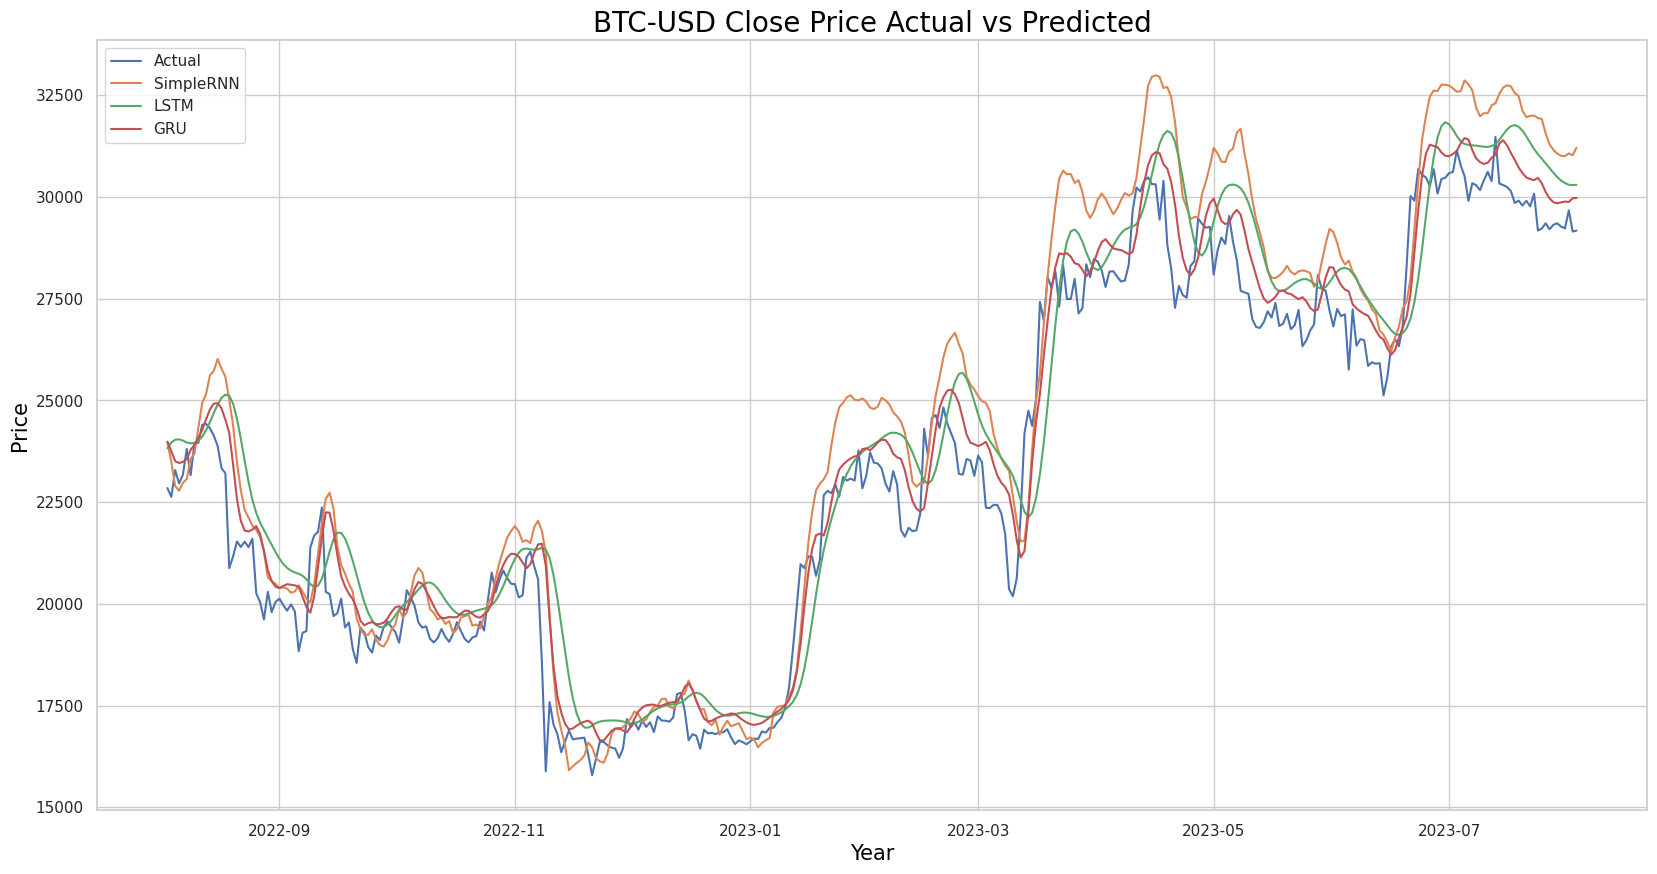

In [40]:
# Plot predicted vs actual values
#train =stock_kode_adj[:training_data_len]
test = stock_kode_adj[training_data_len:]
test['Predictions_SimpleRNN'] = simplernn
test['Predictions_LSTM'] = lstm_pred
test['Predictions_GRU'] = gru_pred

plt.figure(figsize=(20,10))
sns.set_style("whitegrid")
#plt.plot(train['Adj Close'], label='Training')
plt.plot(test['Adj Close'], label='Actual')
plt.plot(test['Predictions_SimpleRNN'], label='SimpleRNN')
plt.plot(test['Predictions_LSTM'], label='LSTM')
plt.plot(test['Predictions_GRU'], label='GRU')
plt.title(stock_kode +" Close Price Actual vs Predicted", color = 'black', fontsize = 20)
plt.xlabel('Year', color = 'black', fontsize = 15)
plt.ylabel('Price', color = 'black', fontsize = 15)
plt.legend();
plt.savefig(stock_kode +"_ActualvsPredict.png")

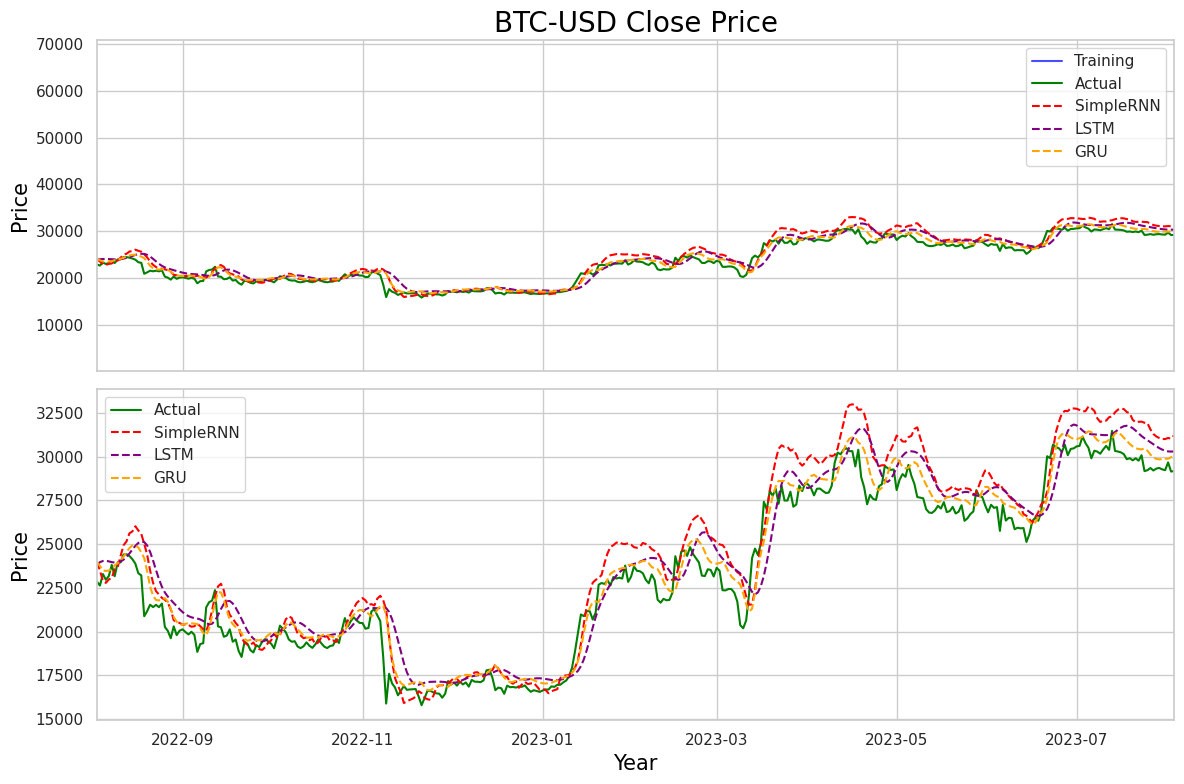

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create subplots with shared x-axis
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
sns.set_style("whitegrid")

# Plot actual training data on the main chart
ax1.plot(stock_kode_adj.index[:training_data_len], stock_kode_adj['Adj Close'][:training_data_len], label='Training', linestyle='-', color='blue', alpha=0.7)

# Plot actual test data on the main chart
ax1.plot(test.index, test['Adj Close'], label='Actual', linestyle='-', color='green')

# Plot predictions on the main chart
ax1.plot(test.index, test['Predictions_SimpleRNN'], label='SimpleRNN', linestyle='--', color='red')
ax1.plot(test.index, test['Predictions_LSTM'], label='LSTM', linestyle='--', color='purple')
ax1.plot(test.index, test['Predictions_GRU'], label='GRU', linestyle='--', color='orange')

# Set title and labels for the main chart
ax1.set_title(stock_kode + " Close Price", color='black', fontsize=20)
ax1.set_ylabel('Price', color='black', fontsize=15)

# Add legend to the main chart
ax1.legend()

# Plot predictions zoomed in on the second chart
ax2.plot(test.index, test['Adj Close'], label='Actual', linestyle='-', color='green')
ax2.plot(test.index, test['Predictions_SimpleRNN'], label='SimpleRNN', linestyle='--', color='red')
ax2.plot(test.index, test['Predictions_LSTM'], label='LSTM', linestyle='--', color='purple')
ax2.plot(test.index, test['Predictions_GRU'], label='GRU', linestyle='--', color='orange')

# Set labels for the second chart
ax2.set_xlabel('Year', color='black', fontsize=15)
ax2.set_ylabel('Price', color='black', fontsize=15)

# Zoom in on the x-axis for the second chart
ax2.set_xlim([test.index[0], test.index[-1]])

# Add legend to the second chart
ax2.legend()

# Save the plot
plt.savefig("BNB-GRU.png")

# Show the plot
plt.tight_layout()
plt.show()


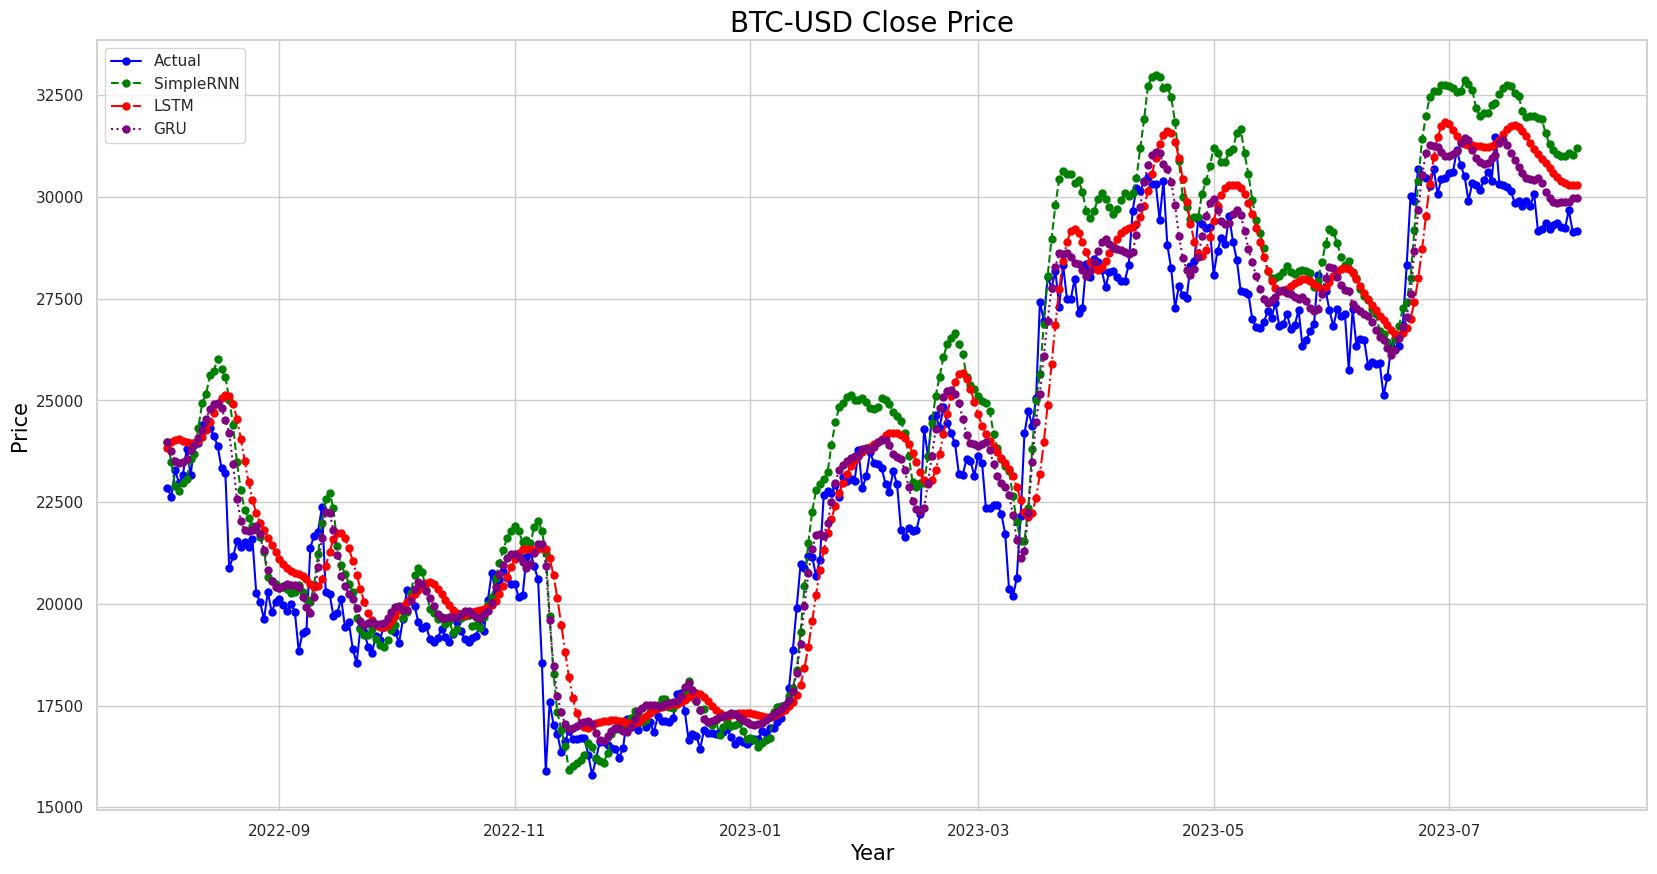

In [42]:
# Plot predicted vs actual values
# train = stock_kode_adj[:training_data_len]
test = stock_kode_adj[training_data_len:]
test['Predictions_SimpleRNN'] = simplernn
test['Predictions_LSTM'] = lstm_pred
test['Predictions_GRU'] = gru_pred

plt.figure(figsize=(20, 10))
sns.set_style("whitegrid")

# Plot actual values in blue
plt.plot(test.index, test['Adj Close'], label='Actual', color='blue', linestyle='-', marker='o', markersize=5)

# Plot SimpleRNN predictions in green
plt.plot(test.index, test['Predictions_SimpleRNN'], label='SimpleRNN', color='green', linestyle='--', marker='o', markersize=5)

# Plot LSTM predictions in red
plt.plot(test.index, test['Predictions_LSTM'], label='LSTM', color='red', linestyle='-.', marker='o', markersize=5)

# Plot GRU predictions in purple
plt.plot(test.index, test['Predictions_GRU'], label='GRU', color='purple', linestyle=':', marker='o', markersize=5)

plt.title(stock_kode + " Close Price", color='black', fontsize=20)
plt.xlabel('Year', color='black', fontsize=15)
plt.ylabel('Price', color='black', fontsize=15)
plt.legend()
plt.savefig("BNB-GRU.png")
plt.show()


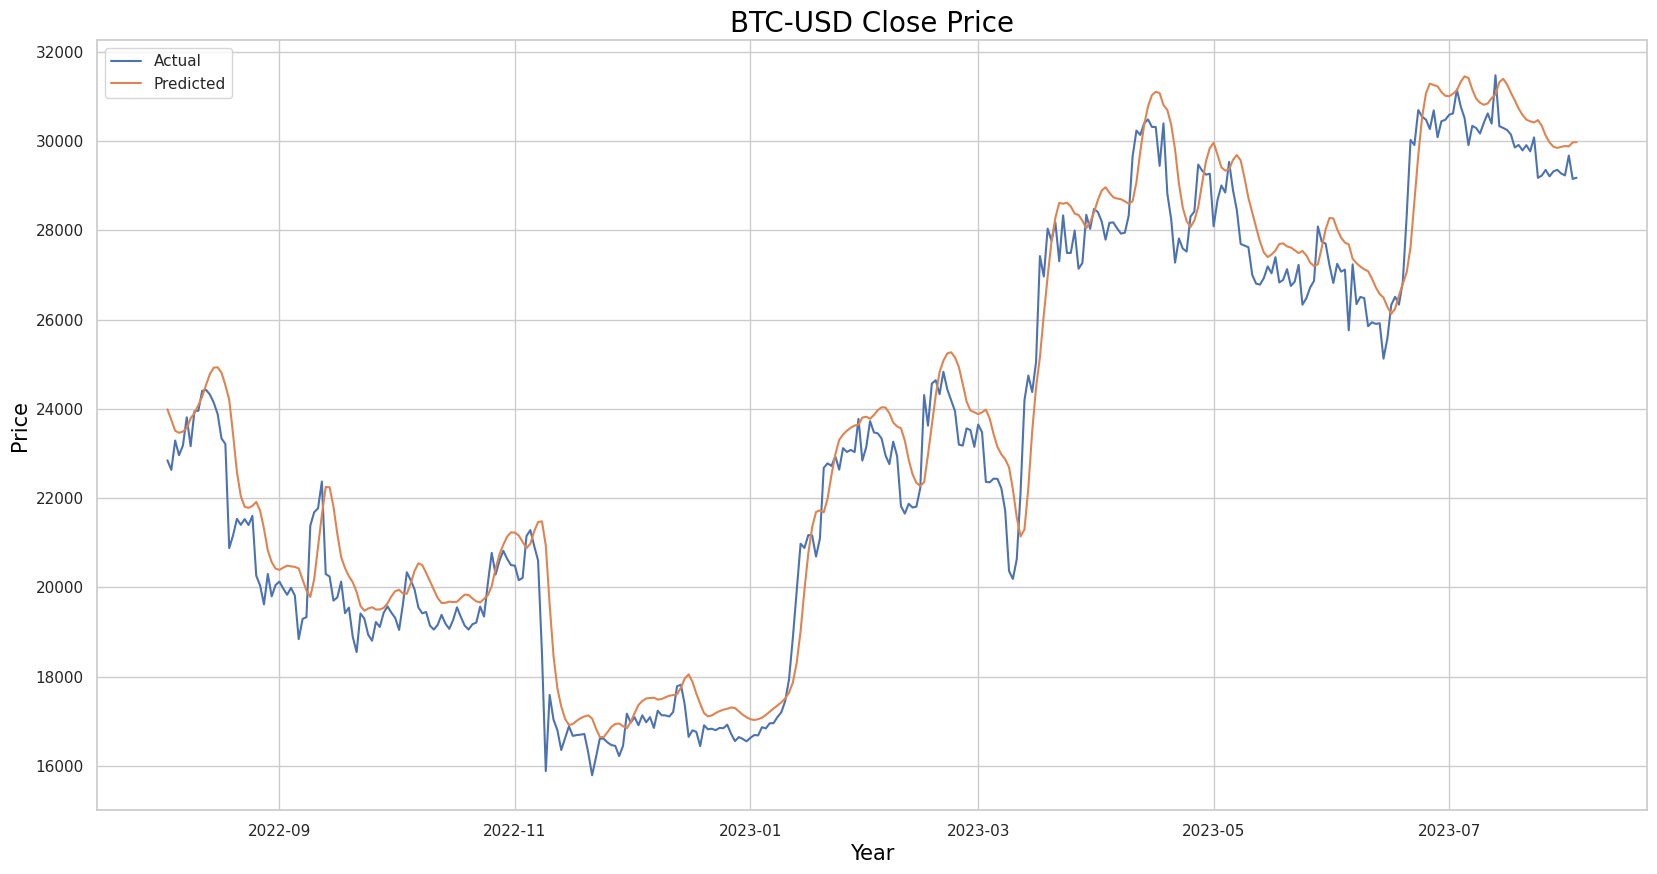

In [43]:
# Plot predicted vs actual values
#train =stock_kode_adj[:training_data_len]
test = stock_kode_adj[training_data_len:]
test['Predictions'] = predictions_gru

plt.figure(figsize=(20,10))
sns.set_style("whitegrid")
#plt.plot(train['Adj Close'], label='Training')
plt.plot(test['Adj Close'], label='Actual')
plt.plot(test['Predictions'], label='Predicted')
plt.title(stock_kode +" Close Price", color = 'black', fontsize = 20)
plt.xlabel('Year', color = 'black', fontsize = 15)
plt.ylabel('Price', color = 'black', fontsize = 15)
plt.legend();
plt.savefig("BNB-GRU.png")

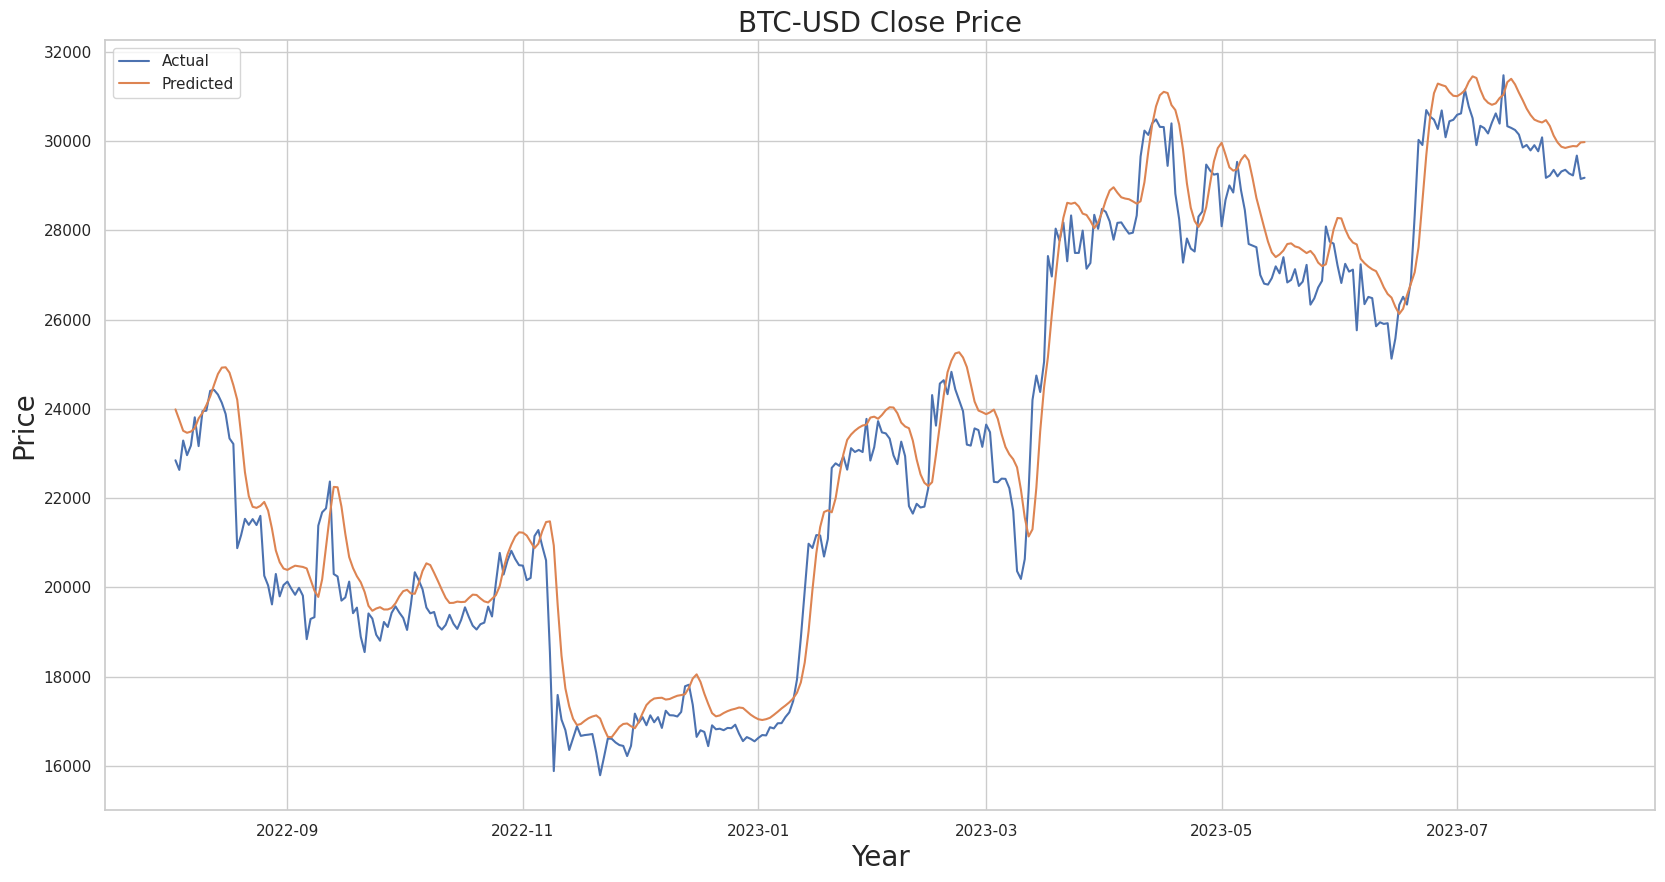

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you already have 'test' DataFrame with 'Adj Close' and 'Predictions' columns

plt.figure(figsize=(20, 10))
sns.set_style("whitegrid")

plt.plot(test['Adj Close'], label='Actual')
plt.plot(test['Predictions'], label='Predicted')
plt.title(stock_kode + " Close Price", fontsize=20)
plt.xlabel('Year', fontsize=20)  # Increase the fontsize here
plt.ylabel('Price', fontsize=20)  # Increase the fontsize here
plt.legend()

plt.savefig("BNB-GRU.png")
plt.show()  # Add this line to display the plot


1/1 [==============================] - 1s 1s/step


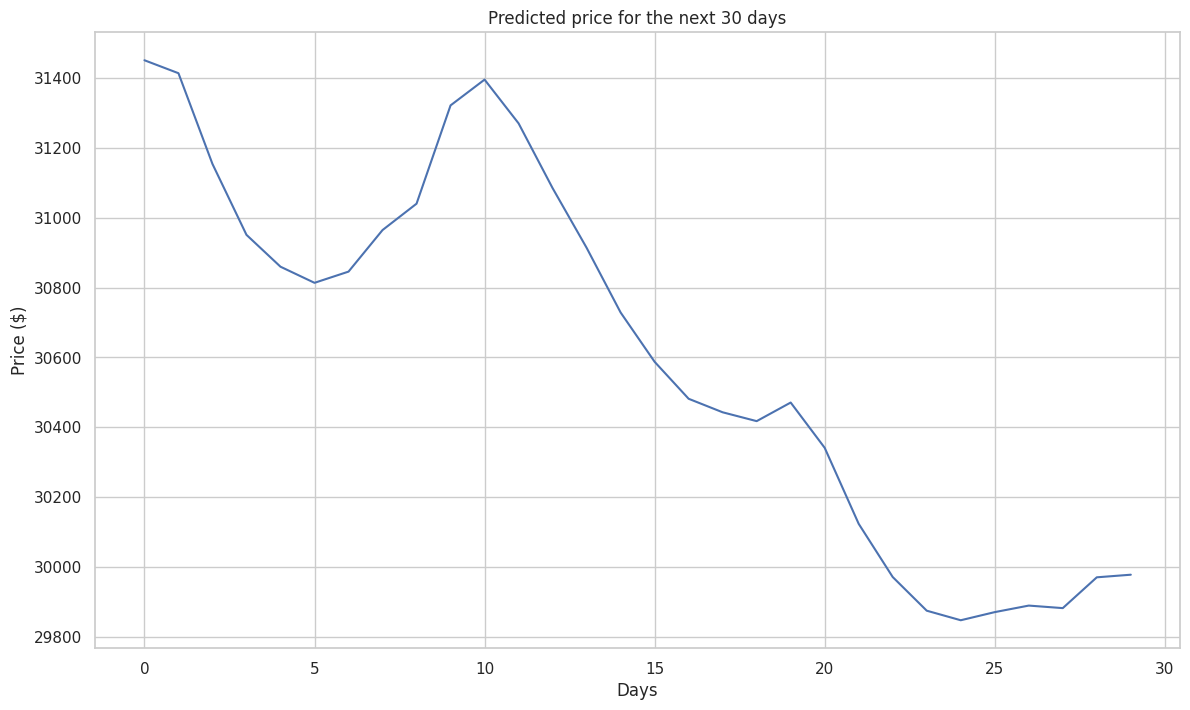

In [45]:
# Predicting 30 days into the future, using past 60 from the train data
future_days = 30
inputs = stock_kode_adj_arr[len(stock_kode_adj_arr) - 60:]
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_future = []
for i in range(future_days, len(inputs)):
    X_future.append(inputs[i-future_days:i, 0])

X_future = np.array(X_future)
X_future = np.reshape(X_future, (X_future.shape[0], X_future.shape[1], 1))

predicted_price = model_gru.predict(X_future)
predicted_price = scaler.inverse_transform(predicted_price)


# Plot the predicted price
plt.plot(predicted_price)
plt.title(f"Predicted price for the next {future_days} days")
plt.xlabel("Days")
plt.ylabel("Price ($)")
plt.show()


In [46]:
# Menampilkan 7 data teratas hasil prediksi
top_7_predicted = predicted_price[:7]
print(top_7_predicted)

[[31451.424]
 [31414.291]
 [31154.354]
 [30951.281]
 [30860.018]
 [30813.87 ]
 [30845.959]]


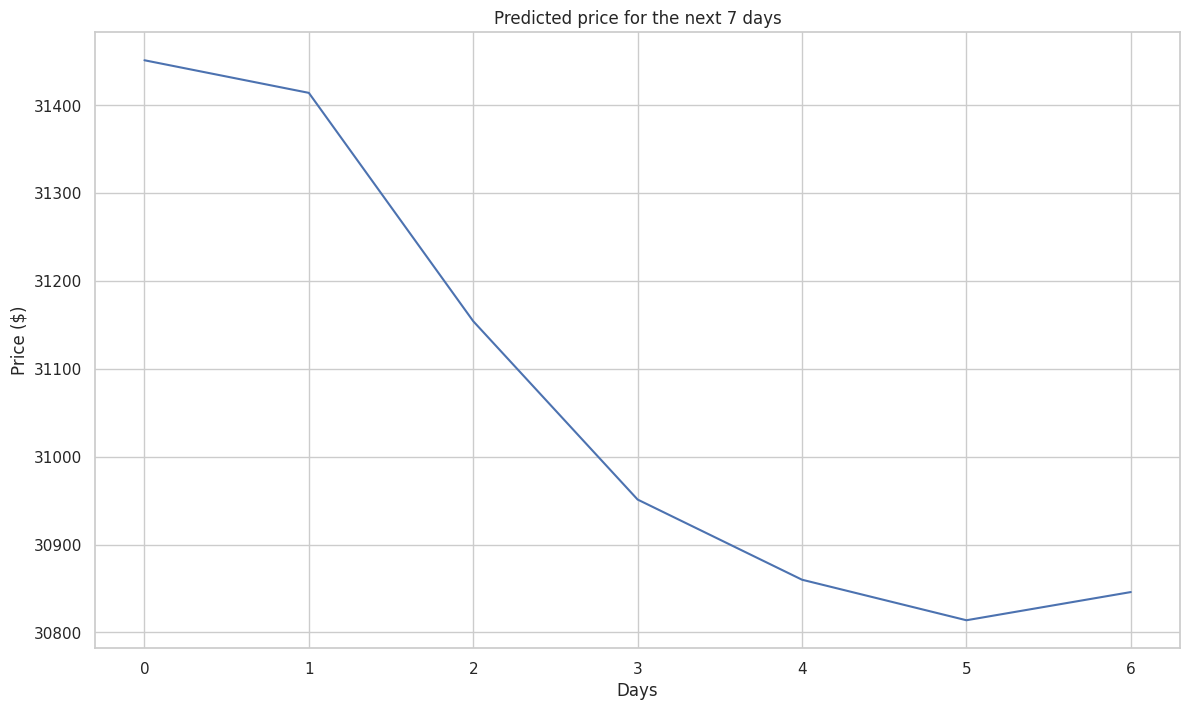

In [47]:
# Plot the predicted price
plt.plot(top_7_predicted)
plt.title(f"Predicted price for the next 7 days")
plt.xlabel("Days")
plt.ylabel("Price ($)")
plt.show()

In [48]:
 # Predicting 60 days into the future, using past 60 from the train data
future_days = 30
inputs = stock_kode_adj_arr[len(stock_kode_adj_arr) - 60:]
inputs = inputs.reshape(-1, 1)
inputs = scaler.transform(inputs)

X_future = []
for i in range(future_days, len(inputs)):
  X_future.append(inputs[i - future_days:i, 0])

X_future = np.array(X_future)
X_future = np.reshape(X_future, (X_future.shape[0], X_future.shape[1], 1))

predicted_price = model_gru.predict(X_future)
predicted_price = scaler.inverse_transform(predicted_price)

# Print the predicted prices and dates
last_date = df['Date'].iloc[-1]


dates = pd.date_range(start=last_date, periods=future_days+1, freq='D')[1:]
for date, price in zip(dates, predicted_price):
    print(f"Predicted price for {date.date()} is {price[0]:.2f} $")

1/1 [==============================] - 0s 21ms/step
Predicted price for 2023-08-04 is 31451.42 $
Predicted price for 2023-08-05 is 31414.29 $
Predicted price for 2023-08-06 is 31154.35 $
Predicted price for 2023-08-07 is 30951.28 $
Predicted price for 2023-08-08 is 30860.02 $
Predicted price for 2023-08-09 is 30813.87 $
Predicted price for 2023-08-10 is 30845.96 $
Predicted price for 2023-08-11 is 30965.00 $
Predicted price for 2023-08-12 is 31040.56 $
Predicted price for 2023-08-13 is 31322.10 $
Predicted price for 2023-08-14 is 31395.99 $
Predicted price for 2023-08-15 is 31270.64 $
Predicted price for 2023-08-16 is 31085.11 $
Predicted price for 2023-08-17 is 30914.21 $
Predicted price for 2023-08-18 is 30728.86 $
Predicted price for 2023-08-19 is 30587.58 $
Predicted price for 2023-08-20 is 30481.71 $
Predicted price for 2023-08-21 is 30443.00 $
Predicted price for 2023-08-22 is 30417.66 $
Predicted price for 2023-08-23 is 30470.94 $
Predicted price for 2023-08-24 is 30341.22 $
Pre

In [49]:
predicted_price

array([[31451.424],
       [31414.291],
       [31154.354],
       [30951.281],
       [30860.018],
       [30813.87 ],
       [30845.959],
       [30964.998],
       [31040.562],
       [31322.102],
       [31395.99 ],
       [31270.645],
       [31085.11 ],
       [30914.209],
       [30728.855],
       [30587.584],
       [30481.709],
       [30442.998],
       [30417.656],
       [30470.936],
       [30341.217],
       [30123.445],
       [29971.12 ],
       [29874.691],
       [29847.31 ],
       [29870.61 ],
       [29889.316],
       [29882.066],
       [29970.305],
       [29977.754]], dtype=float32)